In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from fastai.vision.all import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
import numpy as np
import sahi
from sahi.slicing import slice_image
from sahi.utils.file import save_json
from sahi import DetectionModel
from sahi.utils.cv import read_image
from sahi.predict import get_sliced_prediction
from sahi.models.torchvision import TorchVisionDetectionModel
import torch
import torchvision.models as models

In [3]:
images_folder = "yolo-focused-3"
masks_folder = "focused_masks-3"
path = Path(f'/home/p.kuznetsov/runaway/datasets')

In [3]:
def get_mask_path(image_path):
    return str(image_path).replace(images_folder, masks_folder).replace("/images", "").replace(".jpg", ".png")

In [5]:
segmentation_block = DataBlock(
    blocks=(ImageBlock, MaskBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=get_mask_path,
)

In [6]:
dls = segmentation_block.dataloaders(path/images_folder, path=path, bs=4)  

In [7]:
model = "resnet50"
learn = unet_learner(dls, resnet50, metrics=Dice(), n_out=3)
learn.opt_fn = Adam

In [ ]:
learn.fit(1, 5e-4)

In [ ]:
learn.save(f"{model}-stage-1")

In [ ]:
learn.load(f"{model}-stage-1")

In [ ]:
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

In [ ]:
learn.save(f"{model}-stage-2")

In [ ]:
learn.load(f"{model}-stage-2")

In [ ]:
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

In [ ]:
learn.save(f"{model}-stage-3")

In [ ]:
learn.load(f"{model}-stage-3")

In [ ]:
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

In [ ]:
learn.save(f"{model}-stage-4")

In [8]:
learn.load(f"{model}-stage-4")

/home/p.kuznetsov/.venv/lib/python3.9/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch

In [9]:
learn.export(f"{model}-export.pkl")

In [9]:
learn.validate()

(#2) [0.015522828325629234,0.6194223806961708]

In [ ]:
class FastaiDetectionModel(DetectionModel):
    def check_dependencies(self):
        pass

    def load_model(self):
        self.model = load_learner(self.model_path)
        self.model.model.eval()

    def set_model(self, model):
        self.model = model

    def perform_inference(self, image: np.ndarray):
        # Convert the image to a Fastai PILImage
        image = PILImage.create(image)
        # Perform prediction
        pred_class, pred_idx, outputs = self.model.predict(image)
        

    def get_prediction(self, image):
        pred_class, pred_idx, outputs = self.perform_inference(image)
        # Convert the prediction to the format expected by SAHI

In [5]:
learn = load_learner("./datasets/resnet50-export.pkl")

In [6]:
fastai_model = learn.model
fastai_model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          

In [7]:
torch.save(fastai_model.state_dict(), "./datasets/fastai-resnet50.pth")

In [8]:
torch_model = models.resnet50(pretrained=False)

/home/p.kuznetsov/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/p.kuznetsov/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
torch_model.load_state_dict(torch.load("./datasets/fastai-resnet50.pth"))

/tmp/ipykernel_83342/29867900.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_model.load_state_dict(torch.load("./datasets/fastai-resnet50.pth"))


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "layers.0.0.weight", "layers.0.1.weight", "layers.0.1.bias", "layers.0.1.running_mean", "layers.0.1.running_var", "layers.0.1.num_batches_tracked", "layers.0.4.0.conv1.weight", "layers.0.4.0.bn1.weight", "layers.0.4.0.bn1.bias", "layers.0.4.0.bn1.running_mean", "layers.0.4.0.bn1.running_var", "layers.0.4.0.bn1.num_batches_tracked", "layers.0.4.0.conv2.weight", "layers.0.4.0.bn2.weight", "layers.0.4.0.bn2.bias", "layers.0.4.0.bn2.running_mean", "layers.0.4.0.bn2.running_var", "layers.0.4.0.bn2.num_batches_tracked", "layers.0.4.0.conv3.weight", "layers.0.4.0.bn3.weight", "layers.0.4.0.bn3.bias", "layers.0.4.0.bn3.running_mean", "layers.0.4.0.bn3.running_var", "layers.0.4.0.bn3.num_batches_tracked", "layers.0.4.0.downsample.0.weight", "layers.0.4.0.downsample.1.weight", "layers.0.4.0.downsample.1.bias", "layers.0.4.0.downsample.1.running_mean", "layers.0.4.0.downsample.1.running_var", "layers.0.4.0.downsample.1.num_batches_tracked", "layers.0.4.1.conv1.weight", "layers.0.4.1.bn1.weight", "layers.0.4.1.bn1.bias", "layers.0.4.1.bn1.running_mean", "layers.0.4.1.bn1.running_var", "layers.0.4.1.bn1.num_batches_tracked", "layers.0.4.1.conv2.weight", "layers.0.4.1.bn2.weight", "layers.0.4.1.bn2.bias", "layers.0.4.1.bn2.running_mean", "layers.0.4.1.bn2.running_var", "layers.0.4.1.bn2.num_batches_tracked", "layers.0.4.1.conv3.weight", "layers.0.4.1.bn3.weight", "layers.0.4.1.bn3.bias", "layers.0.4.1.bn3.running_mean", "layers.0.4.1.bn3.running_var", "layers.0.4.1.bn3.num_batches_tracked", "layers.0.4.2.conv1.weight", "layers.0.4.2.bn1.weight", "layers.0.4.2.bn1.bias", "layers.0.4.2.bn1.running_mean", "layers.0.4.2.bn1.running_var", "layers.0.4.2.bn1.num_batches_tracked", "layers.0.4.2.conv2.weight", "layers.0.4.2.bn2.weight", "layers.0.4.2.bn2.bias", "layers.0.4.2.bn2.running_mean", "layers.0.4.2.bn2.running_var", "layers.0.4.2.bn2.num_batches_tracked", "layers.0.4.2.conv3.weight", "layers.0.4.2.bn3.weight", "layers.0.4.2.bn3.bias", "layers.0.4.2.bn3.running_mean", "layers.0.4.2.bn3.running_var", "layers.0.4.2.bn3.num_batches_tracked", "layers.0.5.0.conv1.weight", "layers.0.5.0.bn1.weight", "layers.0.5.0.bn1.bias", "layers.0.5.0.bn1.running_mean", "layers.0.5.0.bn1.running_var", "layers.0.5.0.bn1.num_batches_tracked", "layers.0.5.0.conv2.weight", "layers.0.5.0.bn2.weight", "layers.0.5.0.bn2.bias", "layers.0.5.0.bn2.running_mean", "layers.0.5.0.bn2.running_var", "layers.0.5.0.bn2.num_batches_tracked", "layers.0.5.0.conv3.weight", "layers.0.5.0.bn3.weight", "layers.0.5.0.bn3.bias", "layers.0.5.0.bn3.running_mean", "layers.0.5.0.bn3.running_var", "layers.0.5.0.bn3.num_batches_tracked", "layers.0.5.0.downsample.0.weight", "layers.0.5.0.downsample.1.weight", "layers.0.5.0.downsample.1.bias", "layers.0.5.0.downsample.1.running_mean", "layers.0.5.0.downsample.1.running_var", "layers.0.5.0.downsample.1.num_batches_tracked", "layers.0.5.1.conv1.weight", "layers.0.5.1.bn1.weight", "layers.0.5.1.bn1.bias", "layers.0.5.1.bn1.running_mean", "layers.0.5.1.bn1.running_var", "layers.0.5.1.bn1.num_batches_tracked", "layers.0.5.1.conv2.weight", "layers.0.5.1.bn2.weight", "layers.0.5.1.bn2.bias", "layers.0.5.1.bn2.running_mean", "layers.0.5.1.bn2.running_var", "layers.0.5.1.bn2.num_batches_tracked", "layers.0.5.1.conv3.weight", "layers.0.5.1.bn3.weight", "layers.0.5.1.bn3.bias", "layers.0.5.1.bn3.running_mean", "layers.0.5.1.bn3.running_var", "layers.0.5.1.bn3.num_batches_tracked", "layers.0.5.2.conv1.weight", "layers.0.5.2.bn1.weight", "layers.0.5.2.bn1.bias", "layers.0.5.2.bn1.running_mean", "layers.0.5.2.bn1.running_var", "layers.0.5.2.bn1.num_batches_tracked", "layers.0.5.2.conv2.weight", "layers.0.5.2.bn2.weight", "layers.0.5.2.bn2.bias", "layers.0.5.2.bn2.running_mean", "layers.0.5.2.bn2.running_var", "layers.0.5.2.bn2.num_batches_tracked", "layers.0.5.2.conv3.weight", "layers.0.5.2.bn3.weight", "layers.0.5.2.bn3.bias", "layers.0.5.2.bn3.running_mean", "layers.0.5.2.bn3.running_var", "layers.0.5.2.bn3.num_batches_tracked", "layers.0.5.3.conv1.weight", "layers.0.5.3.bn1.weight", "layers.0.5.3.bn1.bias", "layers.0.5.3.bn1.running_mean", "layers.0.5.3.bn1.running_var", "layers.0.5.3.bn1.num_batches_tracked", "layers.0.5.3.conv2.weight", "layers.0.5.3.bn2.weight", "layers.0.5.3.bn2.bias", "layers.0.5.3.bn2.running_mean", "layers.0.5.3.bn2.running_var", "layers.0.5.3.bn2.num_batches_tracked", "layers.0.5.3.conv3.weight", "layers.0.5.3.bn3.weight", "layers.0.5.3.bn3.bias", "layers.0.5.3.bn3.running_mean", "layers.0.5.3.bn3.running_var", "layers.0.5.3.bn3.num_batches_tracked", "layers.0.6.0.conv1.weight", "layers.0.6.0.bn1.weight", "layers.0.6.0.bn1.bias", "layers.0.6.0.bn1.running_mean", "layers.0.6.0.bn1.running_var", "layers.0.6.0.bn1.num_batches_tracked", "layers.0.6.0.conv2.weight", "layers.0.6.0.bn2.weight", "layers.0.6.0.bn2.bias", "layers.0.6.0.bn2.running_mean", "layers.0.6.0.bn2.running_var", "layers.0.6.0.bn2.num_batches_tracked", "layers.0.6.0.conv3.weight", "layers.0.6.0.bn3.weight", "layers.0.6.0.bn3.bias", "layers.0.6.0.bn3.running_mean", "layers.0.6.0.bn3.running_var", "layers.0.6.0.bn3.num_batches_tracked", "layers.0.6.0.downsample.0.weight", "layers.0.6.0.downsample.1.weight", "layers.0.6.0.downsample.1.bias", "layers.0.6.0.downsample.1.running_mean", "layers.0.6.0.downsample.1.running_var", "layers.0.6.0.downsample.1.num_batches_tracked", "layers.0.6.1.conv1.weight", "layers.0.6.1.bn1.weight", "layers.0.6.1.bn1.bias", "layers.0.6.1.bn1.running_mean", "layers.0.6.1.bn1.running_var", "layers.0.6.1.bn1.num_batches_tracked", "layers.0.6.1.conv2.weight", "layers.0.6.1.bn2.weight", "layers.0.6.1.bn2.bias", "layers.0.6.1.bn2.running_mean", "layers.0.6.1.bn2.running_var", "layers.0.6.1.bn2.num_batches_tracked", "layers.0.6.1.conv3.weight", "layers.0.6.1.bn3.weight", "layers.0.6.1.bn3.bias", "layers.0.6.1.bn3.running_mean", "layers.0.6.1.bn3.running_var", "layers.0.6.1.bn3.num_batches_tracked", "layers.0.6.2.conv1.weight", "layers.0.6.2.bn1.weight", "layers.0.6.2.bn1.bias", "layers.0.6.2.bn1.running_mean", "layers.0.6.2.bn1.running_var", "layers.0.6.2.bn1.num_batches_tracked", "layers.0.6.2.conv2.weight", "layers.0.6.2.bn2.weight", "layers.0.6.2.bn2.bias", "layers.0.6.2.bn2.running_mean", "layers.0.6.2.bn2.running_var", "layers.0.6.2.bn2.num_batches_tracked", "layers.0.6.2.conv3.weight", "layers.0.6.2.bn3.weight", "layers.0.6.2.bn3.bias", "layers.0.6.2.bn3.running_mean", "layers.0.6.2.bn3.running_var", "layers.0.6.2.bn3.num_batches_tracked", "layers.0.6.3.conv1.weight", "layers.0.6.3.bn1.weight", "layers.0.6.3.bn1.bias", "layers.0.6.3.bn1.running_mean", "layers.0.6.3.bn1.running_var", "layers.0.6.3.bn1.num_batches_tracked", "layers.0.6.3.conv2.weight", "layers.0.6.3.bn2.weight", "layers.0.6.3.bn2.bias", "layers.0.6.3.bn2.running_mean", "layers.0.6.3.bn2.running_var", "layers.0.6.3.bn2.num_batches_tracked", "layers.0.6.3.conv3.weight", "layers.0.6.3.bn3.weight", "layers.0.6.3.bn3.bias", "layers.0.6.3.bn3.running_mean", "layers.0.6.3.bn3.running_var", "layers.0.6.3.bn3.num_batches_tracked", "layers.0.6.4.conv1.weight", "layers.0.6.4.bn1.weight", "layers.0.6.4.bn1.bias", "layers.0.6.4.bn1.running_mean", "layers.0.6.4.bn1.running_var", "layers.0.6.4.bn1.num_batches_tracked", "layers.0.6.4.conv2.weight", "layers.0.6.4.bn2.weight", "layers.0.6.4.bn2.bias", "layers.0.6.4.bn2.running_mean", "layers.0.6.4.bn2.running_var", "layers.0.6.4.bn2.num_batches_tracked", "layers.0.6.4.conv3.weight", "layers.0.6.4.bn3.weight", "layers.0.6.4.bn3.bias", "layers.0.6.4.bn3.running_mean", "layers.0.6.4.bn3.running_var", "layers.0.6.4.bn3.num_batches_tracked", "layers.0.6.5.conv1.weight", "layers.0.6.5.bn1.weight", "layers.0.6.5.bn1.bias", "layers.0.6.5.bn1.running_mean", "layers.0.6.5.bn1.running_var", "layers.0.6.5.bn1.num_batches_tracked", "layers.0.6.5.conv2.weight", "layers.0.6.5.bn2.weight", "layers.0.6.5.bn2.bias", "layers.0.6.5.bn2.running_mean", "layers.0.6.5.bn2.running_var", "layers.0.6.5.bn2.num_batches_tracked", "layers.0.6.5.conv3.weight", "layers.0.6.5.bn3.weight", "layers.0.6.5.bn3.bias", "layers.0.6.5.bn3.running_mean", "layers.0.6.5.bn3.running_var", "layers.0.6.5.bn3.num_batches_tracked", "layers.0.7.0.conv1.weight", "layers.0.7.0.bn1.weight", "layers.0.7.0.bn1.bias", "layers.0.7.0.bn1.running_mean", "layers.0.7.0.bn1.running_var", "layers.0.7.0.bn1.num_batches_tracked", "layers.0.7.0.conv2.weight", "layers.0.7.0.bn2.weight", "layers.0.7.0.bn2.bias", "layers.0.7.0.bn2.running_mean", "layers.0.7.0.bn2.running_var", "layers.0.7.0.bn2.num_batches_tracked", "layers.0.7.0.conv3.weight", "layers.0.7.0.bn3.weight", "layers.0.7.0.bn3.bias", "layers.0.7.0.bn3.running_mean", "layers.0.7.0.bn3.running_var", "layers.0.7.0.bn3.num_batches_tracked", "layers.0.7.0.downsample.0.weight", "layers.0.7.0.downsample.1.weight", "layers.0.7.0.downsample.1.bias", "layers.0.7.0.downsample.1.running_mean", "layers.0.7.0.downsample.1.running_var", "layers.0.7.0.downsample.1.num_batches_tracked", "layers.0.7.1.conv1.weight", "layers.0.7.1.bn1.weight", "layers.0.7.1.bn1.bias", "layers.0.7.1.bn1.running_mean", "layers.0.7.1.bn1.running_var", "layers.0.7.1.bn1.num_batches_tracked", "layers.0.7.1.conv2.weight", "layers.0.7.1.bn2.weight", "layers.0.7.1.bn2.bias", "layers.0.7.1.bn2.running_mean", "layers.0.7.1.bn2.running_var", "layers.0.7.1.bn2.num_batches_tracked", "layers.0.7.1.conv3.weight", "layers.0.7.1.bn3.weight", "layers.0.7.1.bn3.bias", "layers.0.7.1.bn3.running_mean", "layers.0.7.1.bn3.running_var", "layers.0.7.1.bn3.num_batches_tracked", "layers.0.7.2.conv1.weight", "layers.0.7.2.bn1.weight", "layers.0.7.2.bn1.bias", "layers.0.7.2.bn1.running_mean", "layers.0.7.2.bn1.running_var", "layers.0.7.2.bn1.num_batches_tracked", "layers.0.7.2.conv2.weight", "layers.0.7.2.bn2.weight", "layers.0.7.2.bn2.bias", "layers.0.7.2.bn2.running_mean", "layers.0.7.2.bn2.running_var", "layers.0.7.2.bn2.num_batches_tracked", "layers.0.7.2.conv3.weight", "layers.0.7.2.bn3.weight", "layers.0.7.2.bn3.bias", "layers.0.7.2.bn3.running_mean", "layers.0.7.2.bn3.running_var", "layers.0.7.2.bn3.num_batches_tracked", "layers.1.weight", "layers.1.bias", "layers.1.running_mean", "layers.1.running_var", "layers.1.num_batches_tracked", "layers.3.0.0.weight", "layers.3.0.0.bias", "layers.3.1.0.weight", "layers.3.1.0.bias", "layers.4.shuf.0.0.weight", "layers.4.shuf.0.0.bias", "layers.4.bn.weight", "layers.4.bn.bias", "layers.4.bn.running_mean", "layers.4.bn.running_var", "layers.4.bn.num_batches_tracked", "layers.4.conv1.0.weight", "layers.4.conv1.0.bias", "layers.4.conv2.0.weight", "layers.4.conv2.0.bias", "layers.5.shuf.0.0.weight", "layers.5.shuf.0.0.bias", "layers.5.bn.weight", "layers.5.bn.bias", "layers.5.bn.running_mean", "layers.5.bn.running_var", "layers.5.bn.num_batches_tracked", "layers.5.conv1.0.weight", "layers.5.conv1.0.bias", "layers.5.conv2.0.weight", "layers.5.conv2.0.bias", "layers.6.shuf.0.0.weight", "layers.6.shuf.0.0.bias", "layers.6.bn.weight", "layers.6.bn.bias", "layers.6.bn.running_mean", "layers.6.bn.running_var", "layers.6.bn.num_batches_tracked", "layers.6.conv1.0.weight", "layers.6.conv1.0.bias", "layers.6.conv2.0.weight", "layers.6.conv2.0.bias", "layers.7.shuf.0.0.weight", "layers.7.shuf.0.0.bias", "layers.7.bn.weight", "layers.7.bn.bias", "layers.7.bn.running_mean", "layers.7.bn.running_var", "layers.7.bn.num_batches_tracked", "layers.7.conv1.0.weight", "layers.7.conv1.0.bias", "layers.7.conv2.0.weight", "layers.7.conv2.0.bias", "layers.8.0.0.weight", "layers.8.0.0.bias", "layers.11.convpath.0.0.weight", "layers.11.convpath.0.0.bias", "layers.11.convpath.1.0.weight", "layers.11.convpath.1.0.bias", "layers.12.0.weight", "layers.12.0.bias". 

In [8]:
test_image_path = "test_images/2020_01.shp/2019-09-01_2019-10-10/default.png"

In [9]:
image = PILImage.create(test_image_path)

In [5]:
detection_model = TorchVisionDetectionModel(
    model=learn.model,
    confidence_threshold=0.6,
    device="cuda",
)

In [41]:
image_np = np.array(image)

In [55]:
detection_model = FastaiDetectionModel(
    model_path="./datasets/resnet50-export.pkl",
    confidence_threshold=0.6,
    device="cuda")
detection_model.load_model()

In [10]:
result = get_sliced_prediction(
    image=image,
    detection_model=detection_model,
    slice_height=224,
    slice_width=224,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

Performing prediction on 81 slices.


AttributeError: 'list' object has no attribute 'orig'

In [15]:
pred_mask, pred_idx, outputs = learn.predict(image)

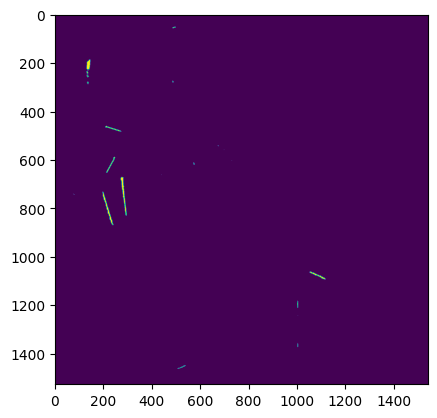

In [19]:
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..197.0].


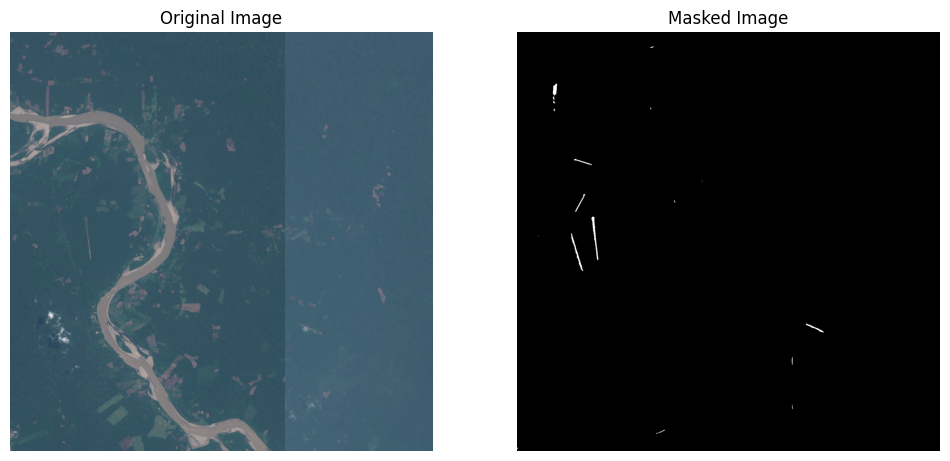

In [24]:
image_np = np.array(image)  # Convert PILImage to numpy array
mask_np = pred_mask.numpy()  # Convert TensorMask to numpy array

# Ensure the mask is in binary form (if needed)
mask_np = (mask_np > 0).astype(np.float32)  # You can customize this threshold if necessary

# Now multiply the image by the mask (you can use the mask to highlight certain regions)
masked_image = image_np * mask_np[..., np.newaxis]  # Adding new axis for the color channels if needed

# Plot the original and masked images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(masked_image)
axes[1].set_title("Masked Image")
axes[1].axis('off')

plt.show()